**FEEL FREE TO UPVOTE**  （＾ｖ＾）

In [0]:
import os
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

from contextlib import contextmanager
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

In [0]:
np.random.seed(4590)

In [0]:
print(os.listdir('../input'))

['elo-dataset', 'continued', 'fork-of-continued', 'elo-merchant-category-recommendation']


In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
train=pd.read_csv('../input/elo-merchant-category-recommendation/train.csv', parse_dates=["first_active_month"])
test=pd.read_csv('../input/elo-merchant-category-recommendation/test.csv', parse_dates=["first_active_month"])

In [0]:
df_hist_trans = pd.read_csv('../input/elo-merchant-category-recommendation/historical_transactions.csv')
df_new_merchant_trans = pd.read_csv('../input/elo-merchant-category-recommendation/new_merchant_transactions.csv')

In [0]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [0]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['category_2'].fillna(1.0,inplace=True)
    df['category_3'].fillna('A',inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

In [0]:
df_hist_trans=reduce_mem_usage(df_hist_trans)
df_new_merchant_trans=reduce_mem_usage(df_new_merchant_trans)

In [0]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['day']=df['purchase_date'].dt.day
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0})
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']
    df['price']=df['purchase_amount']/df['installments']
    df['purchase_amount_quantiles']= pd.qcut(df['purchase_amount'], 5, labels=False)
    df['installments_quantiles']= pd.qcut(df['installments'], 5, labels=False)
gc.collect()

In [0]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size'],
aggs['installments_quantiles']=['var', 'mean', 'skew']
aggs['purchase_amount_quantiles']=['var', 'mean', 'skew']

for col in ['category_2','category_3']:
    df_hist_trans[col+'_mean'] = df_hist_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']    
    
new_columns = get_new_columns('hist',aggs)
df_hist_trans_group = df_hist_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['hist_purchase_date_diff'] = (df_hist_trans_group['hist_purchase_date_max'] - df_hist_trans_group['hist_purchase_date_min']).dt.days
df_hist_trans_group['hist_purchase_date_average'] = df_hist_trans_group['hist_purchase_date_diff']/df_hist_trans_group['hist_card_id_size']
df_hist_trans_group['hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['hist_purchase_date_max']).dt.days
df_hist_trans_group['hist_of_hist_purchase_date_average']=df_hist_trans_group['hist_purchase_date_diff']*df_hist_trans_group['hist_purchase_date_average']

df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group
gc.collect()

In [0]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size'],
aggs['installments_quantiles']=['var', 'mean', 'skew']
aggs['purchase_amount_quantiles']=['var', 'mean', 'skew']


for col in ['category_2','category_3']:
    df_new_merchant_trans[col+'_mean'] = df_new_merchant_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']

new_columns = get_new_columns('new_hist',aggs)
df_hist_trans_group = df_new_merchant_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['new_hist_purchase_date_diff'] = (df_hist_trans_group['new_hist_purchase_date_max'] - df_hist_trans_group['new_hist_purchase_date_min']).dt.days
df_hist_trans_group['new_hist_purchase_date_average'] = df_hist_trans_group['new_hist_purchase_date_diff']/df_hist_trans_group['new_hist_card_id_size']
df_hist_trans_group['new_hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['new_hist_purchase_date_max']).dt.days
df_hist_trans_group['new_hist_of_new_hist_purchase_date_average']=df_hist_trans_group['new_hist_purchase_date_diff']*df_hist_trans_group['new_hist_purchase_date_average']

df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

In [0]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

In [0]:
for df in [df_train,df_test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']
    df['days_feature1'] = df['elapsed_time'] * df['feature_1']    
for f in ['feature_1','feature_2','feature_3']:
    order_label = df_train.groupby([f])['outliers'].mean()
    df_train[f] = df_train[f].map(order_label)
    df_test[f] = df_test[f].map(order_label)

In [0]:
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month', 'target', 'outliers', 'hist_state_wise_installments_mean_sum', 'hist_amount_month_ratio_min', 'hist_amount_month_ratio_skew', 'days_feature2', 'year', 'weekend', 'purchase_amount_ratio', 'hist_amount_month_ratio_min', 'feature_1_mean', 'hist_merchant_month_wise_hist_purchase_amount_mean_min', 'hist_merchant_month_wise_hist_purchase_amount_mean_skew', 'hist_merchant_month_wise_hist_purchase_amount_mean_var', 'hist_merchant_month_wise_hist_purchase_amount_mean_sum', 'hist_merchant_month_wise_hist_purchase_amount_mean_mean', 'hist_category_1_sum', 'new_hist_authorized_flag_mean']]

In [0]:
def score_feature_selection(df_train=None, df_train_columns=None, target=None):
    param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.7,
         "colsample_bytree":0.7,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}

    
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
    oof = np.zeros(len(df_train))
    predictions = np.zeros(len(df_test))
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'])):
        print("fold {}".format(fold_))
        trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
        val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)
        
        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 100)
        oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = df_train_columns
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
        predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

    k=np.sqrt(mean_squared_error(oof, target))
    return k, predictions, feature_importance_df

In [0]:
#feats=[k for k in df_train_columns if k not in list_discarded]
print('no. of features:', len(df_train_columns))
gain_results, predictions, feature_importance_df = score_feature_selection(df_train=df_train, df_train_columns=df_train_columns, target=df_train['target'])
print('\t GAIN  : %.6f' % (gain_results))

best_sub = pd.DataFrame({"card_id":df_test["card_id"].values})
best_sub["target"] = predictions

no. of features: 112
fold 0
Training until validation scores don't improve for 100 rounds.
[200]	training's rmse: 3.58305	valid_1's rmse: 3.6877
[400]	training's rmse: 3.49654	valid_1's rmse: 3.66686
[600]	training's rmse: 3.43941	valid_1's rmse: 3.65714
[800]	training's rmse: 3.39454	valid_1's rmse: 3.65306
[1000]	training's rmse: 3.35652	valid_1's rmse: 3.65086
[1200]	training's rmse: 3.3231	valid_1's rmse: 3.65003
Early stopping, best iteration is:
[1259]	training's rmse: 3.31364	valid_1's rmse: 3.64972
fold 1
Training until validation scores don't improve for 100 rounds.
[200]	training's rmse: 3.58541	valid_1's rmse: 3.68622
[400]	training's rmse: 3.49663	valid_1's rmse: 3.66823
[600]	training's rmse: 3.43811	valid_1's rmse: 3.66165
[800]	training's rmse: 3.39261	valid_1's rmse: 3.65964
[1000]	training's rmse: 3.35495	valid_1's rmse: 3.65865
[1200]	training's rmse: 3.32024	valid_1's rmse: 3.65787
[1400]	training's rmse: 3.28968	valid_1's rmse: 3.65714
Early stopping, best iteration

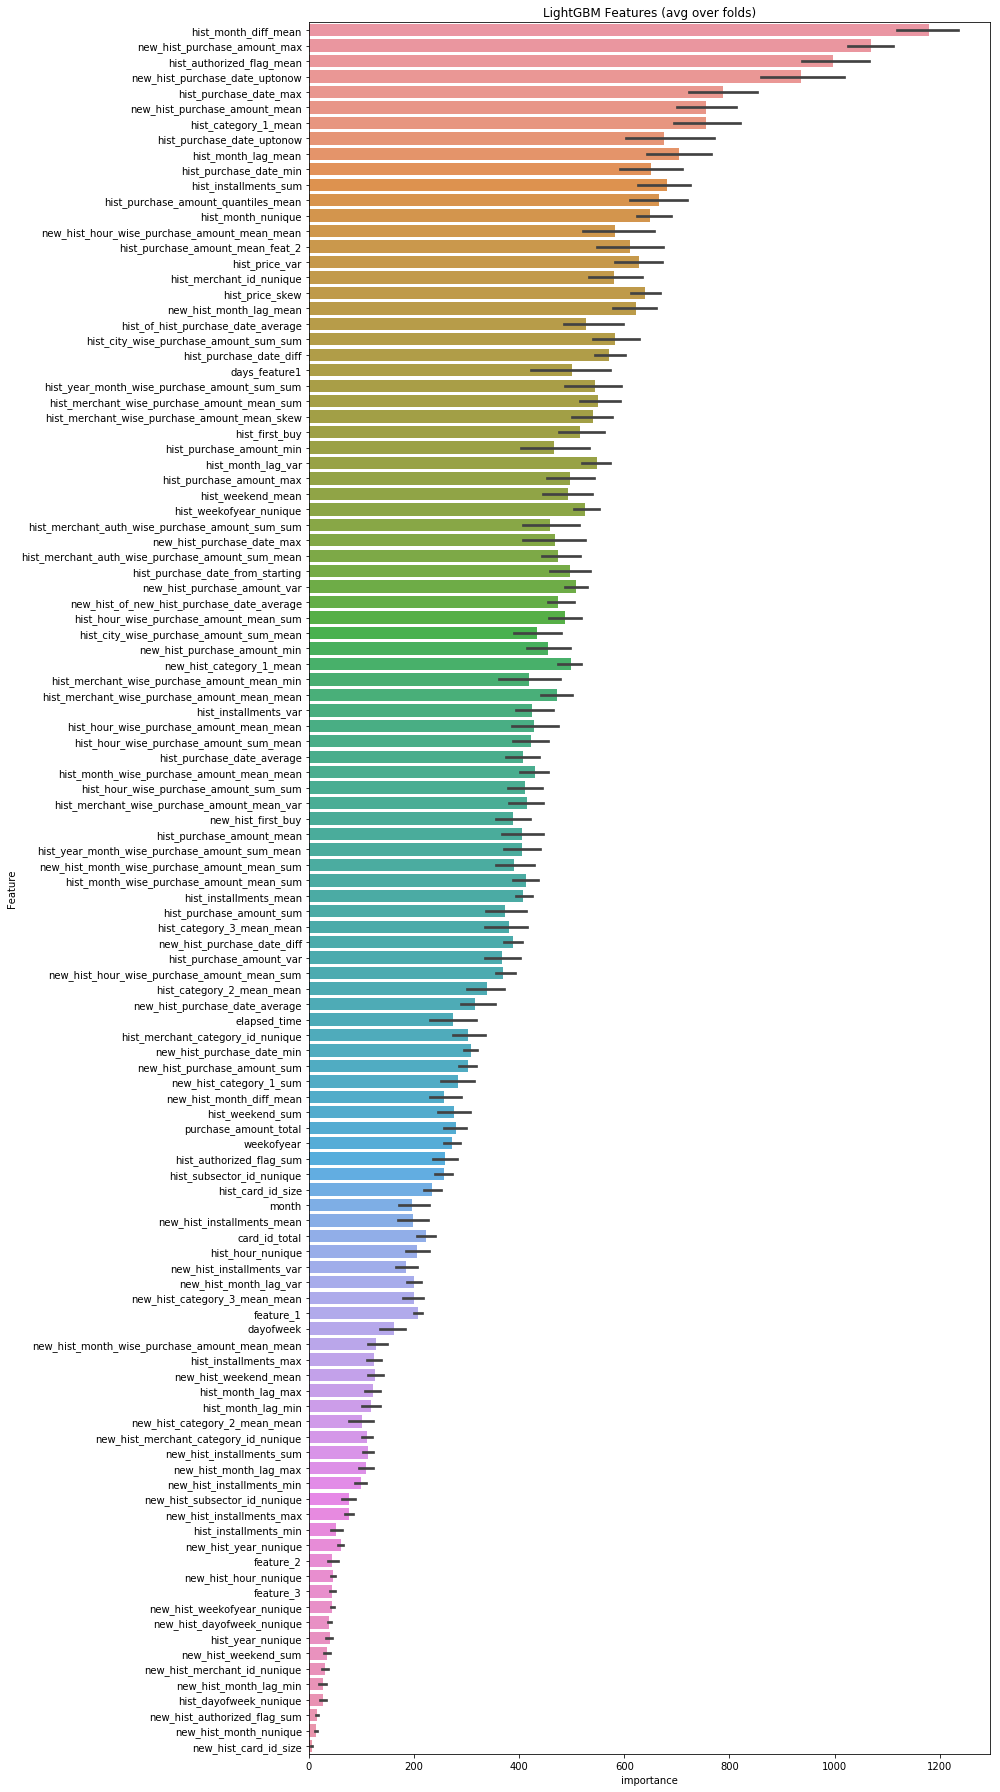

In [0]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False).index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [0]:
predictions

array([-2.36629745, -0.3748086 , -0.84720703, ...,  0.8803943 ,
       -3.11327567,  0.09361591])

In [0]:
df_train=df_train[df_train['outliers']==0]

In [0]:
def score_feature_selection(df_train=None, df_train_columns=None, target=None):
    param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.7,
         "colsample_bytree":0.7,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}

    
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
    oof = np.zeros(len(df_train))
    predictions = np.zeros(len(df_test))
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'])):
        print("fold {}".format(fold_))
        trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
        val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)
        
        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 100)
        oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = df_train_columns
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
        predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

    k=np.sqrt(mean_squared_error(oof, target))
    return k, predictions, feature_importance_df

In [0]:
print('no. of features:', len(df_train_columns))
gain_results, predictions, feature_importance_df = score_feature_selection(df_train=df_train, df_train_columns=df_train_columns, target=df_train['target'])
print('\t GAIN  : %.6f' % (gain_results))

model_without_outlier = pd.DataFrame({"card_id":df_test["card_id"].values})
model_without_outlier["target"] = predictions

no. of features: 112
fold 0
Training until validation scores don't improve for 100 rounds.
[200]	training's rmse: 1.57008	valid_1's rmse: 1.60461
[400]	training's rmse: 1.54486	valid_1's rmse: 1.58782
[600]	training's rmse: 1.53081	valid_1's rmse: 1.58214
[800]	training's rmse: 1.52036	valid_1's rmse: 1.57984
[1000]	training's rmse: 1.51155	valid_1's rmse: 1.57875
[1200]	training's rmse: 1.50361	valid_1's rmse: 1.57807
[1400]	training's rmse: 1.49608	valid_1's rmse: 1.57771
[1600]	training's rmse: 1.48895	valid_1's rmse: 1.57745
[1800]	training's rmse: 1.48199	valid_1's rmse: 1.57724
[2000]	training's rmse: 1.47541	valid_1's rmse: 1.57704
Early stopping, best iteration is:
[1982]	training's rmse: 1.47596	valid_1's rmse: 1.57702
fold 1
Training until validation scores don't improve for 100 rounds.
[200]	training's rmse: 1.576	valid_1's rmse: 1.57795
[400]	training's rmse: 1.55042	valid_1's rmse: 1.56196
[600]	training's rmse: 1.5364	valid_1's rmse: 1.55695
[800]	training's rmse: 1.52582

In [0]:
df_train = pd.read_csv('../input/fork-of-continued/train_1.csv')
df_test = pd.read_csv('../input/fork-of-continued/test_1.csv')

In [0]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import log_loss

In [0]:
def score_feature_selecti_2(df_train=None, df_train_columns=None, target=None):
    param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': 6,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "rf",
         "feature_fraction": 0.7,
         "colsample_bytree":0.7,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'binary_logloss',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}

    
    folds = KFold(n_splits=5, shuffle=True, random_state=4590)
    oof = np.zeros(len(df_train))
    predictions = np.zeros(len(df_test))
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values,target.values)):
        print("fold {}".format(fold_))
        trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
        val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)
        
        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 100)
        oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = df_train_columns
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
        predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

    k=log_loss(target, oof)
    return k, predictions, feature_importance_df

In [0]:
print('no. of features:', len(df_train_columns))
gain_results, predictions, feature_importance_df = score_feature_selecti_2(df_train=df_train, df_train_columns=df_train_columns, target=df_train['outliers'])
print('\t GAIN  : %.6f' % (gain_results))

df_outlier_prob = pd.DataFrame({"card_id":df_test["card_id"].values})
df_outlier_prob["target"] = predictions

no. of features: 112
fold 0
Training until validation scores don't improve for 100 rounds.
[200]	training's binary_logloss: 0.0434619	valid_1's binary_logloss: 0.046935
[400]	training's binary_logloss: 0.0434248	valid_1's binary_logloss: 0.0468875
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.0434282	valid_1's binary_logloss: 0.0468832
fold 1
Training until validation scores don't improve for 100 rounds.
[200]	training's binary_logloss: 0.0442164	valid_1's binary_logloss: 0.0446043
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0442062	valid_1's binary_logloss: 0.0445617
fold 2
Training until validation scores don't improve for 100 rounds.
[200]	training's binary_logloss: 0.0439852	valid_1's binary_logloss: 0.0461728
Early stopping, best iteration is:
[167]	training's binary_logloss: 0.0439557	valid_1's binary_logloss: 0.0461381
fold 3
Training until validation scores don't improve for 100 rounds.
[200]	training's binary_logloss: 0.0438413

In [0]:
outlier_id = df_outlier_prob[df_outlier_prob['target']>0.5]
outliers=outlier_id['card_id']

In [0]:
most_likely_liers = best_sub.merge(outlier_id,how='right')
most_likely_liers.head()

,card_id,target
0,C_ID_0ab67a22ab,-2.366297
1,C_ID_f7cada36d3,0.400746
2,C_ID_6d8dba8475,-0.859223
3,C_ID_7f1041e8e1,-3.895403
4,C_ID_22e4a47c72,-0.350261


In [0]:
%%time
for card_id in most_likely_liers['card_id']:
    model_without_outlier.loc[model_without_outlier['card_id']==card_id,'target']\
    = most_likely_liers.loc[most_likely_liers['card_id']==card_id,'target'].values

CPU times: user 5min 58s, sys: 272 ms, total: 5min 58s
Wall time: 5min 58s


In [0]:
model_without_outlier.to_csv("combining_submission.csv", index=False)